In [9]:
import pandas as pd

rapm_2023 = pd.read_csv("rapm_2023.csv")
rapm_2024 = pd.read_csv("rapm_2024.csv")
rapm_2025 = pd.read_csv("rapm_2025.csv")

rapm_2023['season'] = 2023
rapm_2024['season'] = 2024
rapm_2025['season'] = 2025

combined_rapm = pd.concat([rapm_2023, rapm_2024, rapm_2025], ignore_index=True)
combined_rapm["even_xgf_percentile"] = combined_rapm.groupby(["season", "position"])["even_xgf"].rank(pct=True)
combined_rapm["even_xga_percentile"] = 1 - combined_rapm.groupby(["season", "position"])["even_xga"].rank(pct=True)
combined_rapm["pp_xgf_percentile"] = combined_rapm.groupby(["season", "position"])["pp_xgf"].rank(pct=True)
combined_rapm["pk_xga_percentile"] = 1 - combined_rapm.groupby(["season", "position"])["pk_xga"].rank(pct=True)

In [18]:
# standard deployments
even = 1000
pp = 100
pk = 100

even_rapm = (combined_rapm["even_xgf"] - combined_rapm["even_xga"]) * (even / 60)
pp_rapm = (combined_rapm["pp_xgf"] * (pp / 60))
pk_rapm = -(combined_rapm["pk_xga"] * (pk / 60))

rapm = combined_rapm[['playerId', 'name', 'position', 'season']].copy()
rapm['rapm'] = even_rapm + pp_rapm + pk_rapm
rapm['evo'] = combined_rapm['even_xgf_percentile'] 
rapm['evd'] = combined_rapm['even_xga_percentile']
rapm['ppo'] = combined_rapm['pp_xgf_percentile']
rapm['pkd'] = combined_rapm['pk_xga_percentile']
rapm["rapm_rank"] = rapm.groupby(["season", "position"])["rapm"].rank(pct=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_player_rapm(player_name):
    # Try both name and playerId
    player_data = rapm[rapm['name'] == player_name]
    if player_data.empty:
        player_data = rapm[rapm['playerId'] == player_name]
    if player_data.empty:
        print("Player not found.")
        return
    
    plt.figure(figsize=(12, 7))

    metrics = {
        'rapm_rank': 'Overall RAPM',
        'evo': 'Even Strength Offense',
        'evd': 'Even Strength Defense',
        'ppo': 'Power Play Offense',
        'pkd': 'Penalty Kill Defense'
    }

    for col, label in metrics.items():
        df = player_data.sort_values('season')

        # Seasons before 2025 → solid
        solid_df = df[df['season'] < 2025]
        if len(solid_df) >= 2:
            plt.plot(
                solid_df['season'],
                solid_df[col],
                marker='o',
                label=label
            )
        elif len(solid_df) == 1:
            plt.plot(solid_df['season'], solid_df[col], marker='o')

        # Segment leading into 2025 → dotted only for that segment
        if 2025 in df['season'].values:
            seg = df[df['season'].isin([df['season'].max() - 1, 2025])]
            if len(seg) == 2:
                plt.plot(
                    seg['season'],
                    seg[col],
                    marker='o',
                    linestyle=':',
                    color=plt.gca().lines[-1].get_color()
                )
                
    plt.ylim(-0.05, 1.05)
    plt.title(f'RAPM Over Seasons for {player_name}')
    plt.xlabel('Season')
    plt.ylabel('Percentile Rank')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


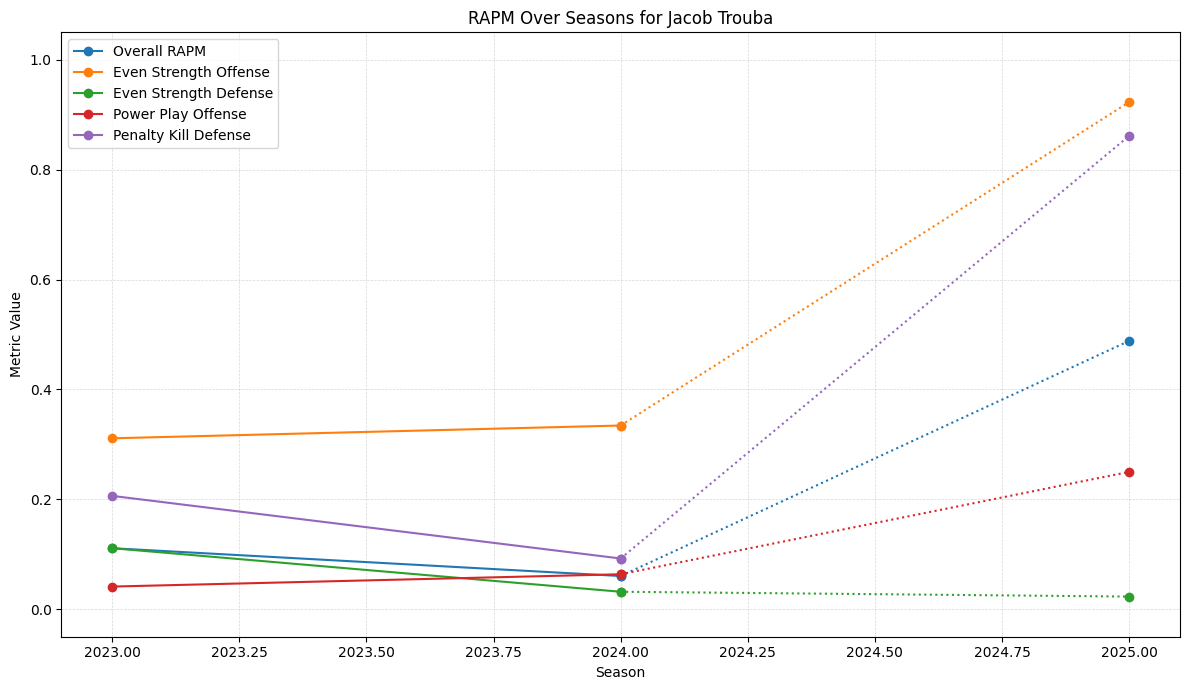

In [41]:
plot_player_rapm("Jacob Trouba")